# Réalisez une veille technologique
## Sentence-BERT - Feature Importance
OpenClassrooms - Parcours Data Scientist - Projet 08  

## Présentation du projet

**Contexte**  

* Le modèle LogisticRegression permet de classifier de manière correcte (accuracy = 0.97) dans leur catégorie les produits de __Place de marché__
* Cette classification repose sur les embeddings générés par __Sentence-BERT__, obtenus à partir des descriptions textuelles des produits  
* L'analyse des feature importances globale et locale, via la librairie SHAP, permet de mesurer l'impact des features constituant les embeddings (vecteurs de dimension 384).
* Le fait de ne pas pouvoir calculer l'impact des mots constituant les descriptions, rend cependant difficile l'interprétation du modèle  

**Objectif**  
* L'objectif de ce notebook est de palier à ce manque d'interprétabilité en tenant de réaliser les calculs de feature importance manuellement, de manière simplifiée

__Méthodologie__  

- **Extraction de l'embedding** Sentence-BERT `E`, à partir de la variable 'description' du produit
- **Récupération de la description tokenizée** `T` sous forme texte
- **Génération des probabilités** `P(E)` d'appartenance à chaque classe via LogisticRegression, à partir de l'embedding `E`  
- Pour chaque token `t` de la description tokenizée `T` du produit :  
    - **Suppression temporaire du token** `t` de la description  
    - **Extraction de l'embedding** Sentence-BERT `E(t)`, à partir de la variable 'description' amputée du token `t`  
    - **Génération des probabilités** `P(E(t))` d'appartenance à chaque classe via LogisticRegression, à partir de l'embedding `E(t)`  
    - **Calcul de la feature importance locale** `F(t)` du token t pour chaque classe par soustraction `P(E) - P(E(t))`  
- **Calcul de la feature importance globale** par calcul de la moyenne des valeurs absolues de `F(t)`, pour tous les tokens `t`   

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc8_note


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import time
import textwrap

## Données

### Chargement

In [3]:
# Conversion du fichier csv en DataFrame
df_datas = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv', usecols=['product_category_tree', 'description'])

### Extraction des variables cible et d'input

__Variable cible__

In [4]:
# Création variable 'category' par récupération du texte entre '["' et la première occurence de ' >>'
df_datas['category'] = df_datas['product_category_tree'].apply(lambda x: x.split('["')[1].split(' >>')[0])

# Suppression colonne inutile
df_datas.drop(columns='product_category_tree', inplace=True)

In [5]:
# Traduction
traduction = {
    'Home Furnishing': 'Ameublement',
    'Baby Care': 'Bébés',
    'Watches': 'Montres',
    'Home Decor & Festive Needs': 'Décoration',
    'Kitchen & Dining': 'Cuisine',
    'Beauty and Personal Care': 'Beauté',
    'Computers': 'Informatique'
}

df_datas['category'] = df_datas['category'].replace(traduction)

In [6]:
y_true = df_datas['category']

__Variable d'input__

In [7]:
# df_datas['description'] = df_datas['description'].str.lower()
descriptions = df_datas['description'].str.lower()

## Transformation des descriptions en tokens S-BERT lisibles

__Chargement du tokenizer et du modèle__

In [8]:
# Chargement depuis HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
sbert_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

__Transformations__

In [9]:
sbert_sentences = []

for sentences in descriptions:
    # Tokenizasition des descriptions
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    
    # Conversion des token IDs en tokens de forme texte
    tokens_text = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])

    # Nettoyage, reconsitution des mots, reconsitution des phrases
    new_token = []
    for i, token in enumerate(tokens_text):
        if token in ('[CLS]', '[SEP]', '[PAD]', '[MASK]', '[UNK]'):
            continue
        if token.startswith('##'):
            new_token[-1] += token[2:]
        else:
            new_token.append(token)
    sbert_sentences.append(' '.join(new_token))

# Ajout des phrases reconstituées au DataFrame
df_datas['description sbert'] = sbert_sentences

In [10]:
# Exemple de description
print(df_datas['description'].values[-1])

Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


In [11]:
# Exemple de description tokenozée
print(*tokens_text)

[CLS] buy uber ##ly ##fe large vinyl stick ##er for rs . 59 ##5 online . uber ##ly ##fe large vinyl stick ##er at best prices with free shipping & cash on delivery . only genuine products . 30 day replacement guarantee . [SEP]


In [12]:
# Exemple de description tokenizée puis retransformée en texte
print(*new_token)

buy uberlyfe large vinyl sticker for rs . 595 online . uberlyfe large vinyl sticker at best prices with free shipping & cash on delivery . only genuine products . 30 day replacement guarantee .


__Vérification de la similitude entre embeddings obtenus à partir des desriptions d'origine et ceux à partir des descritpions transformées__

In [13]:
# Source : https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [14]:
def get_sbert_embedding(encoded_input):
    # Compute token embeddings
    with torch.no_grad():
        model_output = sbert_model(**encoded_input)
    
    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    
    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    return sentence_embeddings

In [15]:
# Stockage des index des produits mal transformés
differences = []

# Stockage des embeddings
embeddings = []

for index in df_datas.index:
    desc_orig = df_datas['description'][index]
    desc_sbert = df_datas['description sbert'][index]
    
    embedding_orig = get_sbert_embedding(tokenizer(desc_orig, padding=True, truncation=True, return_tensors='pt'))
    embedding_sbert = get_sbert_embedding(tokenizer(desc_sbert, padding=True, truncation=True, return_tensors='pt'))

    # Sauvegarde des embeddings
    embedding_numpy = embedding_sbert.numpy().flatten()
    embeddings.append(embedding_numpy)

    # Vérification d'une éventuelle différence
    if not torch.allclose(embedding_orig, embedding_sbert, atol=1e-5):
        differences.append(index)

if differences:
    print(f"Index des produits dont les embeddings sont différents : {','.join(differences)}")
else:
    print("Aucune différence dans les embedding avant / après transformation")

Aucune différence dans les embedding avant / après transformation


## Entraînement du modèle de classification

In [16]:
# Encodage des categories
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_datas['category'])

# Récupération des noms de catégorie à partir des labels
label_to_category = {index: label for index, label in enumerate(label_encoder.classes_)}

X = np.array(embeddings)
# Split jeu d'entraînement / jeu de test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df_datas.index, test_size=0.2, random_state=96)

# Entraînement
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Feature importance globale

La feature importance globale est la moyenne des importances des tokens, il est donc nécessaire de commencer par les calculer ces dernières sur l'ensemble du dataset.

In [17]:
def get_token_importance(index, description, token):
    # Embedding et probas description complète
    original_embedding = embeddings[index]
    original_probas = model.predict_proba([original_embedding])[0]
    
    # Suppression du token et recalcul embedding et probas
    modified_description = description.replace(token, '')
    tokenized = tokenizer([modified_description], padding=True, truncation=True, return_tensors='pt')

    modified_embedding = get_sbert_embedding(tokenizer([modified_description], padding=True, truncation=True, return_tensors='pt')).numpy().flatten()
    modified_probas = model.predict_proba([modified_embedding])[0]
    
    # Calcul de l'importance locale
    importance = original_probas - modified_probas

    return importance

__Importances des tokens S-BERT__

In [18]:
token_importances = {}

for i, description in enumerate(df_datas['description sbert']):
    for token in set(description.split()):
        importance = get_token_importance(i, description, token)
        if token not in token_importances:
            token_importances[token] = []
        token_importances[token].append(importance)

__Importance globale__

In [19]:
# Moyenne des valeurs absolues des token importances
global_importance = [[token, np.mean(np.abs(importances))] for token, importances in token_importances.items()]

# Tri par importance décroissante
global_importance.sort(key=lambda x:x[1], reverse=True)

In [20]:
max_display = 20

In [21]:
# Extraction du top 'max_display'
features = [feature[0] for feature in global_importance[:max_display]]
importances = [importance[1] for importance in global_importance[:max_display]]

In [22]:
# Somme des importances des tokens hors Top
sum_of_other_importances = sum([importance[1] for importance in global_importance[max_display:]])
number_of_other_tokens = len(global_importance) - max_display

__Visualisation des tokens ayant le plus d'impact sur les prédictions__

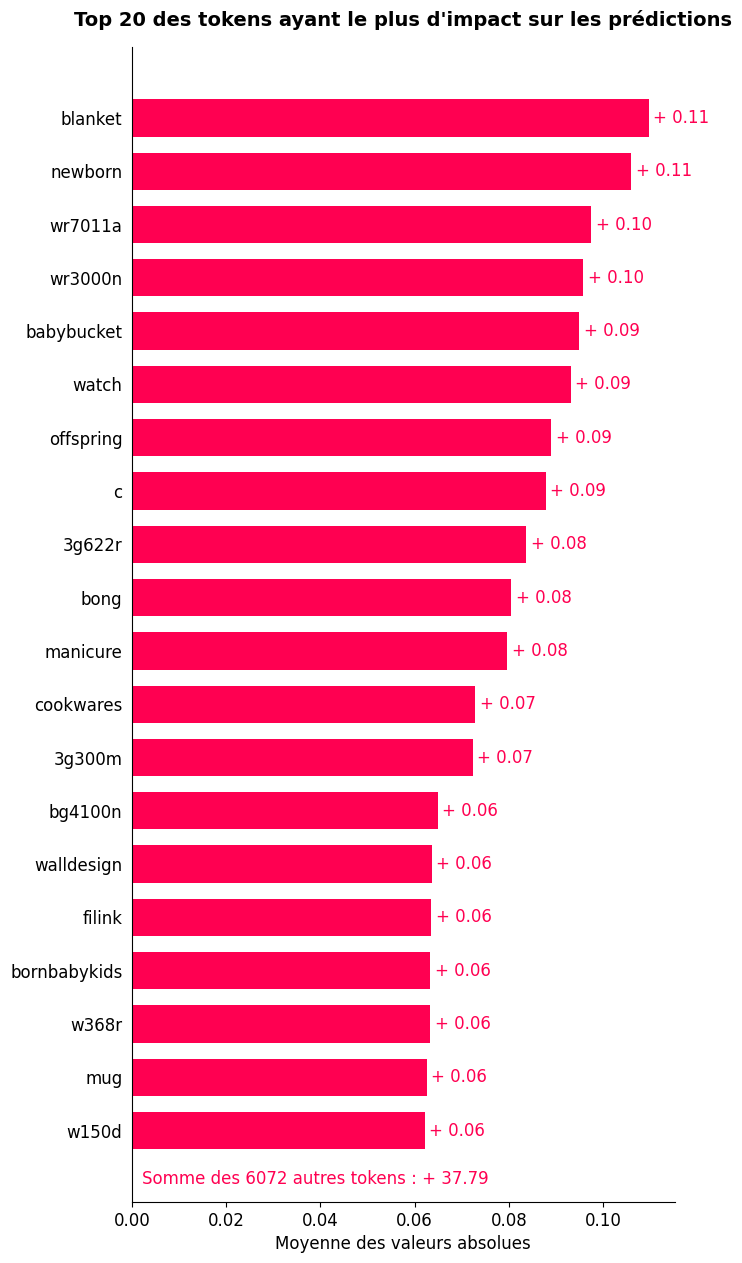

In [23]:
import matplotlib.pyplot as plt

# Bar plot
color = '#FF0051'
fig, ax = plt.subplots(figsize=(7, 15))
bars = ax.barh(features, importances, color=color, height=0.7)

# Affichage des valeurs à cotés des barres
for bar in bars:
    xval = bar.get_width()
    yval = bar.get_y() + bar.get_height() / 2
    ax.text(xval + 0.001, yval, f'+ {xval:.2f}', ha='left', va='center', color=color, fontsize=12)

# Ajout valeur autres tokens
ax.text(0.002, max_display, f"Somme des {number_of_other_tokens} autres tokens : + {sum_of_other_importances:.2f}", color=color, fontsize=12)

# Suppression des cadres haut et droite
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Gestion des axes x / y
ax.tick_params(axis='x', labelsize=12)
ax.set_xlabel('Moyenne des valeurs absolues', fontsize=12)
ax.tick_params(axis='y', length=0, pad=7, labelsize=12)
ax.set_ylabel('')

# Inversion ordre des barres pour que le token avec la plus grande importance soit en haut
plt.gca().invert_yaxis()

# Titre
ax.set_title(f"Top {max_display} des tokens ayant le plus d'impact sur les prédictions", fontweight='bold', fontsize=14, pad=15)

plt.show()

## Feature importance locale

In [24]:
def get_local_importance(index):
    description = df_datas['description sbert'][index]
    local_importance = []

    for token in set(description.split()):
        if len(token) > 2:
            token_importance = get_token_importance(index, description, token)
            local_importance.append([token, token_importance])
    return local_importance

In [25]:
# Sélection du produit
index = 88

In [26]:
# Nombre de tokens à afficher
max_display = 10

__Vérification catégorie prédite / catégorie réelle__

En cas d'erreur de prédiction, il sera intéressant de comparer l'impact qu'ont eut les tokens de la description sur la catégorie réelle et la catégorie prédite.

In [27]:
labels = []

# Labels prédit / réel
pred = model.predict([embeddings[index]])[0]
real = y[index]

labels.append(pred)
if pred != real:
    labels.append(real)

__Importances locales__

In [28]:
local_importances = {}

local_importance = get_local_importance(index)
max_display = min(10, len(local_importance))

for label in labels:
    local_importance.sort(key=lambda x:abs(x[1][label]), reverse=True)
    features = [feature[0] for feature in local_importance[:max_display]]
    importances = [importance[1][label] for importance in local_importance]

    # Normalisation des importances
    total = abs(sum(importances))
    importances = [importance / total for importance in importances][:max_display]

    local_importances[label_to_category[label]] = [features, importances]

__Visualisations__

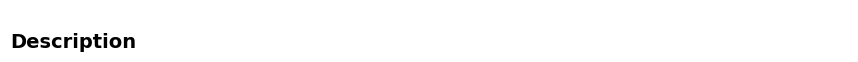

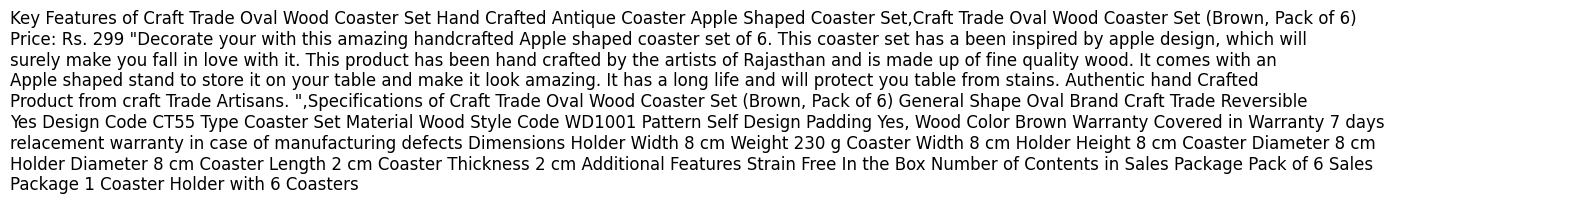

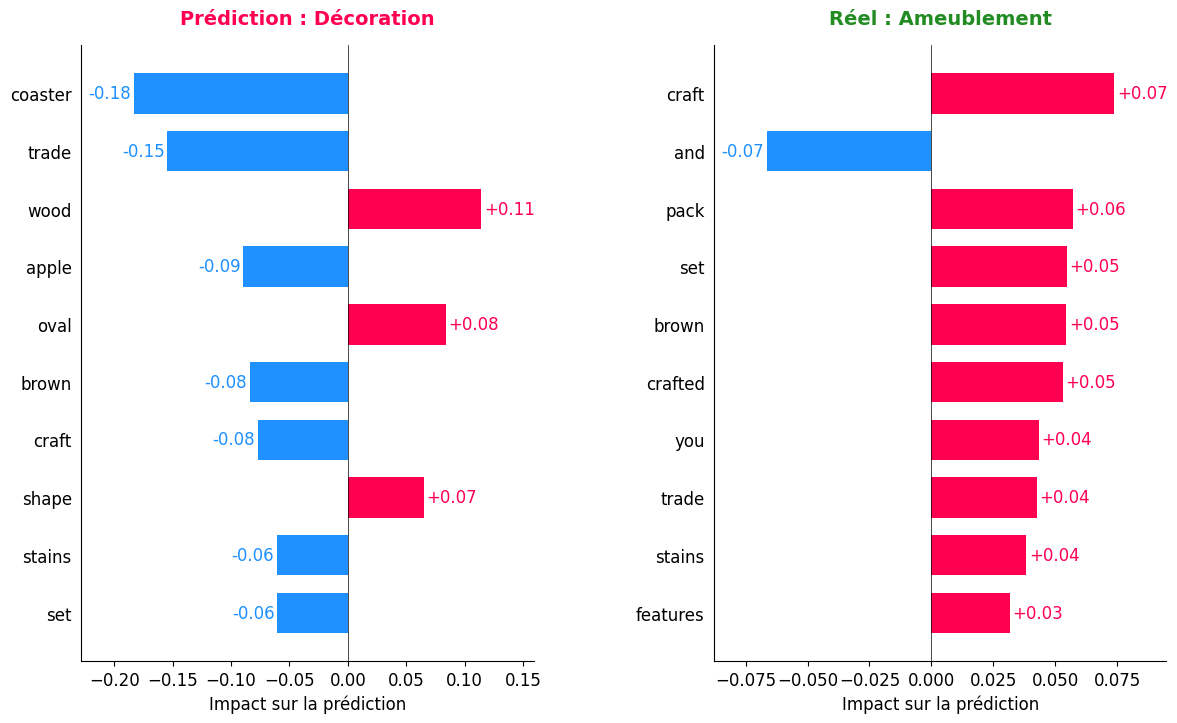

In [29]:
product_description = df_datas.loc[index, 'description']

num_of_plots = len(local_importances)

# Affichage de la description d'origine du produit
wrapper = textwrap.TextWrapper(width=79 * num_of_plots)  
description = wrapper.fill(text=product_description) 

# Titre
plt.figure(figsize=(10, 0.5))
plt.text(0, 0, "Description", ha='center', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

# Description
plt.figure(figsize=(10 * num_of_plots, 0.1))
plt.text(0, 0, description, ha='left', va='center', fontsize=12)
plt.axis('off')
plt.show()

# Affichage des barplots (un seul si prédiction = réel)
if num_of_plots == 1:
    fig, ax = plt.subplots(figsize=(7, 8))
else:
    fig, axs = plt.subplots(1, 2, figsize=(14, 8))

for label_index, label in enumerate(labels):
    category = label_to_category[label]
    features = local_importances[category][0]
    importances = local_importances[category][1]

    if num_of_plots == 2:
        ax = axs[label_index]
        
    colors = ['#FF0051' if val > 0 else '#1E90FF' for val in importances]
    bars = ax.barh(features, importances, color=colors, height=0.7)
    
    # Espace entre l'axe des y et les barres
    min_importance = min(importances)
    max_importance = max(importances)
    margin = (abs(min_importance) + max_importance) * 0.15
    left_margin, right_margin = min_importance - margin, max_importance + margin
    ax.set_xlim(left=left_margin, right=right_margin)
    
    # Ajout des valeurs des barres
    for i, bar in enumerate(bars):
        xval = bar.get_width()
        delta = margin / 20
        distance = delta if (xval > 0) else -delta
        yval = bar.get_y() + bar.get_height() / 2
        value = f'{xval:+.2f}'
        ax.text(xval + distance, yval, value, ha='left' if xval > 0 else 'right', va='center', color=colors[i], fontsize=12)
    
    ax.set_xlabel('Impact sur la prédiction', fontsize=12)
    ax.set_ylabel('')
    if num_of_plots == 1:
        title = f"Prédiction / réel : {label_to_category[label]}"
        color = 'forestgreen'
    else:
        title = f"{('Prédiction', 'Réel')[label_index]} : {label_to_category[label]}"
        color = f"{('#FF0051', 'forestgreen')[label_index]}"
    ax.set_title(title, fontweight='bold', fontsize=14, pad=15, color=color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=0, color='black', linewidth=0.5)  # Ligne verticale à x=0 pour indiquer la séparation positive/négative
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', length=0, pad=7, labelsize=12)
    ax.invert_yaxis()  # Inverser l'axe y pour que le token avec la plus grande importance soit en haut

if num_of_plots > 1:
    plt.subplots_adjust(wspace=0.4)
    
plt.show()